In [ ]:
# !pip install gensim
# !pip install fugashi[unidic]
# !python -m unidic download

# 整形処理
1. テキストデータの読み込み
2. 整形処理
3. 辞書・コーパスの作成

In [11]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [15]:
import os

# Load the livedoor news corpus
path_to_corpus = '../../text'  # 事前にDLして解凍が必要（https://www.rondhuit.com/download.html）
documents = []
for category in os.listdir(path_to_corpus):
    if category in ['CHANGES.txt', 'README.txt']:
        continue
    category_path = os.path.join(path_to_corpus, category)
    for file in os.listdir(category_path):
        if file in ['LICENSE.txt']:
            continue
        file_path = os.path.join(category_path, file)
        with open(file_path, 'r') as f:
            url = f.readline()  # １行目：記事のURL
            date = f.readline()  # ２行目：記事の日付
            title = f.readline()  # ３行目：記事のタイトル
            documents.append(f.read())  # ４行目以降：記事の本文


In [16]:
import re
import requests
from fugashi import Tagger

# ストップワードの準備
url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# 全角半角文字以外（記号と数字）を正規表現を使って除去
pattern = r"[^\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\u20000-\u2ffff\sa-zA-Z]"
documents = [re.sub(pattern, "", text) for text in documents]

# Mecabで分かち書きして、単語に分割
tagger = Tagger('-Owakati')
documents = [tagger.parse(text).split() for text in documents]

# ストップワードの除去
documents = [[word for word in text if not word in stopwords]for text in documents]

# 1文字は除去
documents = [[word for word in text if len(word) > 1]for text in documents]

print(sum([len(text) for text in documents]))

2070594


In [17]:
from gensim.corpora import Dictionary, MmCorpus
from sklearn.model_selection import train_test_split

# 辞書の作成、保存、読み込み
dictionary = Dictionary(documents)
dictionary.save('livedoor.dict')
dictionary = Dictionary.load('livedoor.dict')

# コーパスの作成、分割、保存、読み込み
corpus = [ dictionary.doc2bow(text) for text in documents]
doc_train, doc_test = train_test_split(corpus, test_size=0.2)
print(corpus[0][:10])
MmCorpus.serialize('./doc_train.mm', doc_train)
MmCorpus.serialize('./doc_test.mm', doc_test)
doc_train = MmCorpus('doc_train.mm')
doc_test = MmCorpus('doc_test.mm')
print(doc_train)
print(doc_test)


2023-01-20 12:53:46,260 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-01-20 12:53:47,146 : INFO : built Dictionary<71140 unique tokens: ['10', '11', '111029', '2005', '2006']...> from 7367 documents (total 2070594 corpus positions)
2023-01-20 12:53:47,146 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<71140 unique tokens: ['10', '11', '111029', '2005', '2006']...> from 7367 documents (total 2070594 corpus positions)", 'datetime': '2023-01-20T12:53:47.146882', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'created'}
2023-01-20 12:53:47,152 : INFO : Dictionary lifecycle event {'fname_or_handle': 'livedoor.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-01-20T12:53:47.152154', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platfor

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)]


2023-01-20 12:53:47,997 : INFO : PROGRESS: saving document #3000
2023-01-20 12:53:48,084 : INFO : PROGRESS: saving document #4000
2023-01-20 12:53:48,175 : INFO : PROGRESS: saving document #5000
2023-01-20 12:53:48,254 : INFO : saved 5893x71140 matrix, density=0.244% (1024097/419228020)
2023-01-20 12:53:48,255 : INFO : saving MmCorpus index to ./doc_train.mm.index
2023-01-20 12:53:48,256 : INFO : storing corpus in Matrix Market format to ./doc_test.mm
2023-01-20 12:53:48,256 : INFO : saving sparse matrix to ./doc_test.mm
2023-01-20 12:53:48,257 : INFO : PROGRESS: saving document #0
2023-01-20 12:53:48,345 : INFO : PROGRESS: saving document #1000
2023-01-20 12:53:48,390 : INFO : saved 1474x71133 matrix, density=0.245% (256947/104850042)
2023-01-20 12:53:48,390 : INFO : saving MmCorpus index to ./doc_test.mm.index
2023-01-20 12:53:48,396 : INFO : loaded corpus index from doc_train.mm.index
2023-01-20 12:53:48,397 : INFO : initializing cython corpus reader from doc_train.mm
2023-01-20 12:

MmCorpus(5893 documents, 71140 features, 1024097 non-zero entries)
MmCorpus(1474 documents, 71133 features, 256947 non-zero entries)


おまけ
- NumPy および SciPy との互換性
    - Gensim には、Numpy 行列との変換を支援する効率的なユーティリティ関数も含まれています。意外とよく使います
- ベクトルの正規化（単位ベクトル化）

In [18]:
from gensim import matutils
# Dense2Corpus
import numpy as np
numpy_matrix = np.random.randint(10, size=[5, 2])  # random matrix as an example
corpus = matutils.Dense2Corpus(numpy_matrix)

# Sparse2Corpus
import scipy.sparse
scipy_sparse_matrix = scipy.sparse.random(5, 2)  # random sparse matrix as example
corpus = matutils.Sparse2Corpus(scipy_sparse_matrix)
scipy_csc_matrix = matutils.corpus2csc(corpus)

# Sparce2full
bow = [(1,22), (45, 1)]
bow_np = matutils.sparse2full(bow, 100)

# unitvec
bow_np_norm = matutils.unitvec(bow_np)
np.sqrt(np.dot(bow_np_norm,bow_np_norm,))

1.0

TFIDFの答え
- pprintを使うとプリティーにprintしてくれます。

In [19]:
from gensim.corpora import Dictionary, MmCorpus
from gensim import models

# 演習1-6,7で作成した辞書、コーパスを読み込む
dictionary = Dictionary.load('livedoor.dict')
corpus_train = MmCorpus('doc_train.mm')
corpus_test = MmCorpus('doc_test.mm')

# corpus_trainをTFIDFモデルの作成と保存
tfidf = models.TfidfModel(corpus_train)
tfidf.save('tfidf.model')

# corpus_test[0][:10]を使って、変換前（BagOfWords）と変換後（TFIDF）をプリントして比較
from pprint import pprint
pprint([f"単語：{dictionary[before[0]]}, 変換前: {before[1]}, 変換後:{after[1]}"  for before, after in zip(corpus_test[0][:10], tfidf[corpus_test[0]][:10])])

2023-01-20 12:53:50,453 : INFO : loading Dictionary object from livedoor.dict
2023-01-20 12:53:50,472 : INFO : Dictionary lifecycle event {'fname': 'livedoor.dict', 'datetime': '2023-01-20T12:53:50.472655', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'loaded'}
2023-01-20 12:53:50,476 : INFO : loaded corpus index from doc_train.mm.index
2023-01-20 12:53:50,476 : INFO : initializing cython corpus reader from doc_train.mm
2023-01-20 12:53:50,477 : INFO : accepted corpus with 5893 documents, 71140 features, 1024097 non-zero entries
2023-01-20 12:53:50,477 : INFO : loaded corpus index from doc_test.mm.index
2023-01-20 12:53:50,478 : INFO : initializing cython corpus reader from doc_test.mm
2023-01-20 12:53:50,478 : INFO : accepted corpus with 1474 documents, 71133 features, 256947 non-zero entries
2023-01-20 12:53:50,478 : INFO : collecting document frequencies
2023-01-20 1

['単語：21, 変換前: 1.0, 変換後:0.024729763555466425',
 '単語：ある, 変換前: 1.0, 変換後:0.003751664709258531',
 '単語：いう, 変換前: 1.0, 変換後:0.002955107966292036',
 '単語：いる, 変換前: 2.0, 変換後:0.0027861095377936483',
 '単語：その, 変換前: 2.0, 変換後:0.010010728569258982',
 '単語：だけ, 変換前: 1.0, 変換後:0.008479509343784433',
 '単語：つける, 変換前: 1.0, 変換後:0.03777808002512007',
 '単語：ない, 変換前: 5.0, 変換後:0.01108662279815237',
 '単語：なかっ, 変換前: 1.0, 変換後:0.01517250044699044',
 '単語：なっ, 変換前: 1.0, 変換後:0.004023407100236087']


類似度の答え
- 最も似ているドキュメントは自分自身

In [20]:
from gensim.corpora import MmCorpus
from gensim import models
from gensim import similarities
import numpy as np

# 演習2-1で作成したコーパスとTFIDFモデルを読み込む
corpus_test = MmCorpus('doc_test.mm')
tfidf = models.TfidfModel.load('tfidf.model')

# クエリを受け取り、TFIDFモデルを使って、類似度を計算するためのモジュールを呼び出します。
index = similarities.MatrixSimilarity(tfidf[corpus_test])

# TFIDFモデルを作るときに使ったコーパスの先頭から５個（corpus_test[:5]）それぞれをクエリーとして類似度を計算して、最も似ているドキュメントのインデックをprintしてください。
for i in range(5):
    best_sim_id = np.argmax(index[corpus_test[i]])
    print(f"{i}と最も似ているのはドキュメントは{best_sim_id}")

2023-01-20 12:53:51,342 : INFO : loaded corpus index from doc_test.mm.index
2023-01-20 12:53:51,343 : INFO : initializing cython corpus reader from doc_test.mm
2023-01-20 12:53:51,343 : INFO : accepted corpus with 1474 documents, 71133 features, 256947 non-zero entries
2023-01-20 12:53:51,344 : INFO : loading TfidfModel object from tfidf.model
2023-01-20 12:53:51,363 : INFO : TfidfModel lifecycle event {'fname': 'tfidf.model', 'datetime': '2023-01-20T12:53:51.363110', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'loaded'}
2023-01-20 12:53:51,364 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2023-01-20 12:53:51,568 : INFO : creating matrix with 1474 documents and 70825 features


0と最も似ているのはドキュメントは0
1と最も似ているのはドキュメントは1
2と最も似ているのはドキュメントは2
3と最も似ているのはドキュメントは3
4と最も似ているのはドキュメントは4


### BagOfWordsとTFIDFの類似度行列の回答

In [21]:
from gensim.corpora import MmCorpus
from gensim import models
from gensim import similarities
import numpy as np

corpus_test = MmCorpus('doc_test.mm')

tfidf = models.TfidfModel.load('tfidf.model')
index = similarities.MatrixSimilarity(tfidf[corpus_test[:10]], num_features=corpus_test.num_terms)
similarity_gensim = index[corpus_test[:10]]
similarity_gensim.shape


2023-01-20 12:53:52,249 : INFO : loaded corpus index from doc_test.mm.index
2023-01-20 12:53:52,266 : INFO : initializing cython corpus reader from doc_test.mm
2023-01-20 12:53:52,275 : INFO : accepted corpus with 1474 documents, 71133 features, 256947 non-zero entries
2023-01-20 12:53:52,284 : INFO : loading TfidfModel object from tfidf.model
2023-01-20 12:53:52,325 : INFO : TfidfModel lifecycle event {'fname': 'tfidf.model', 'datetime': '2023-01-20T12:53:52.325054', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'loaded'}
2023-01-20 12:53:52,328 : INFO : creating matrix with 10 documents and 71133 features


(10, 10)

In [22]:
import numpy as np
from gensim.corpora import MmCorpus
from gensim import matutils
from gensim import models
from gensim import similarities

tfidf = models.TfidfModel.load('tfidf.model')
corpus_test = MmCorpus('doc_test.mm')

A_bow = matutils.corpus2dense(corpus_test[:10], num_docs=10, num_terms=corpus_test.num_terms).T
A_tfidf = matutils.corpus2dense(tfidf[corpus_test[:10]], num_docs=10, num_terms=corpus_test.num_terms).T
A_tfidf_norm = A_tfidf /np.linalg.norm(A_tfidf, axis=1, keepdims=True)
A_bow_norm = A_bow / np.linalg.norm(A_bow, axis=1, keepdims=True)
similarity_matrix = np.dot(A_tfidf_norm, A_bow_norm.T)


# A_bow =   np.asarray([matutils.unitvec(matutils.sparse2full(vec, corpus_test.num_terms)) for vec in corpus_test[:10]])
# A_tfidf =  np.asarray([matutils.unitvec(matutils.sparse2full(vec, corpus_test.num_terms)) for vec in tfidf[corpus_test[:10]]])

# # 行列の積を取っているだけ
# # https://github.com/RaRe-Technologies/gensim/blob/f35faae7a7b0c3c8586fb61208560522e37e0e7e/gensim/similarities/docsim.py#L876
# similarity_matrix = np.dot(A_tfidf, A_bow.T)

similarity_matrix.shape

2023-01-20 12:53:52,616 : INFO : loading TfidfModel object from tfidf.model
2023-01-20 12:53:52,631 : INFO : TfidfModel lifecycle event {'fname': 'tfidf.model', 'datetime': '2023-01-20T12:53:52.631940', 'gensim': '4.3.0', 'python': '3.9.6 (default, Sep 26 2022, 11:37:49) \n[Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5.1-arm64-arm-64bit', 'event': 'loaded'}
2023-01-20 12:53:52,633 : INFO : loaded corpus index from doc_test.mm.index
2023-01-20 12:53:52,633 : INFO : initializing cython corpus reader from doc_test.mm
2023-01-20 12:53:52,634 : INFO : accepted corpus with 1474 documents, 71133 features, 256947 non-zero entries


(10, 10)

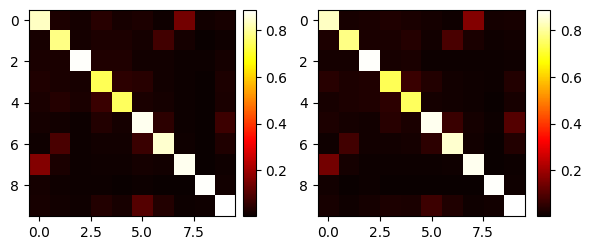

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4, hspace=0.6)

im_0 = ax[0].imshow(similarity_gensim, cmap='hot')
axpos = ax[0].get_position()
cbar_ax = fig.add_axes([0.46, axpos.y0, 0.02, axpos.height])
cbar = fig.colorbar(im_0, cax=cbar_ax)

im_1 = ax[1].imshow(similarity_matrix, cmap='hot')
axpos = ax[1].get_position()
cbar_ax = fig.add_axes([0.92, axpos.y0, 0.02, axpos.height])
cbar = fig.colorbar(im_1, cax=cbar_ax)